# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [3]:
df = pd.read_csv('bank_fin.csv', sep = ';')

### Задание 1

In [4]:
# найдем пропущенные значения,их количнство в %, столбцы с ними
display(df.isnull().sum())

display(f'Количество пропусков в признаке "balance":')
display(f'{25} из общего количества {df.shape[0]} или {round(25/df.shape[0]*100, 2)} %')

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

'Количество пропусков в признаке "balance":'

'25 из общего количества 11162 или 0.22 %'

### Задание 2

In [5]:
# найдем в признаке job пропущенные значения, которые обозначены специальным словом
display(df['job'].value_counts())

print(f'Количество значений unknown в признаке job: {df[df["job"] == "unknown"].shape[0]}')

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Количество значений unknown в признаке job: 70


### Задание 3

In [6]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].astype (float)

In [7]:
print(round(df["balance"].mean(), 3))

1529.129


### Задание 4

In [8]:
# обработаем пропуски в признаки balance, заменив их на медианные значения
df['balance'].fillna(df['balance'].median(), inplace=True)

print(round(df["balance"].mean(), 3))

1526.936


### Задание 5

In [9]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_moda = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: job_moda if x == 'unknown' else x)

edu_moda = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: edu_moda if x == 'unknown' else x)

print(round(df[(df['job'] == job_moda) & (df['education'] == edu_moda)]['balance'].mean(), 3))

1598.883


### Задание 6

In [10]:
# очистим от выбросов признак balance используя метод Тьюки

def find_outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Находит выбросы в данных, используя метод межквартильного размаха.
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
        lower_bound, upper_bound: нижняя и верхняя границы, определяющие выбросы
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

df_outliers, df_cleand, lower_bound, upper_bound = find_outliers_iqr(df, 'balance')

print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')
print(f'Оставшееся количество объектов после удаления выбросов: {df_cleand.shape[0]}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Оставшееся количество объектов после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

Text(0.5, 0.98, 'Распределение целевой переменной (сбалансированность классов)')

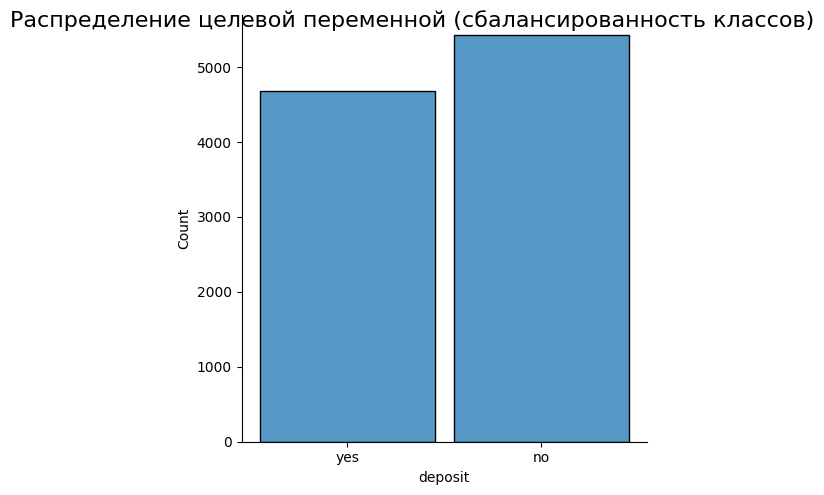

In [11]:
# изучим соотношение классов (распределение целевой переменной)
# на предмет несбалансированности
display(df_cleand['deposit'].value_counts())

# построим гисторамму распределения целевой переменной (сбалансированность классов)
dep_hist = sns.displot(df_cleand, x='deposit', shrink=.9)
dep_hist.figure.suptitle(
    'Распределение целевой переменной (сбалансированность классов)', 
    fontsize=16)

### Задания 2 и 3

In [12]:
# рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат
df_cleand.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Text(0.5, 0.98, 'Распределение age')

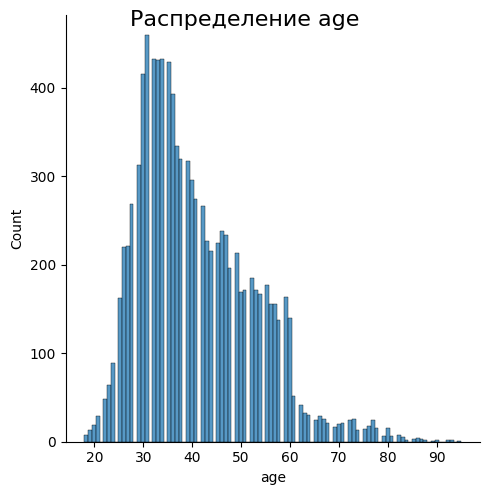

In [13]:

age_hist = sns.displot(df_cleand, x='age', bins=100)
age_hist.figure.suptitle(
    'Распределение age', 
    fontsize=16)

Распределение возраста адекватное. Аномалий нет. Возраст от 18 до 95 лет. Основная масса с 21 года (совершеннолетие) и до 60+ (выход на пенсию). Распределение нормальное.

Text(0.5, 0.98, 'Распределение balance')

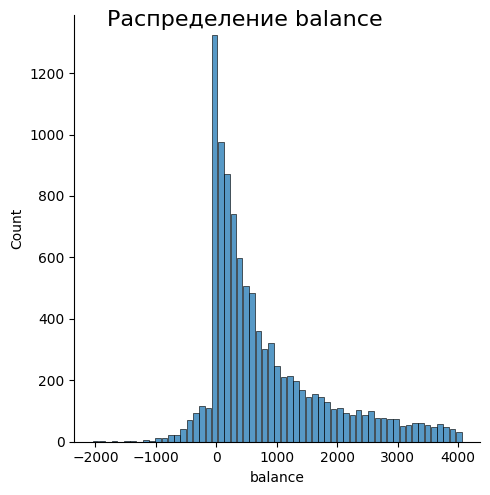

In [14]:
bal_hist = sns.displot(df_cleand, x='balance', shrink=.9)
bal_hist.figure.suptitle(
    'Распределение balance', 
    fontsize=16)

Распределение баланса адекватное. Аномалий нет. После удаления выбросов (примерно 9 %) от - 2000 до 4100. Положительного подавляющее количество. Распределение нормальное.

Text(0.5, 0.98, 'Распределение day')

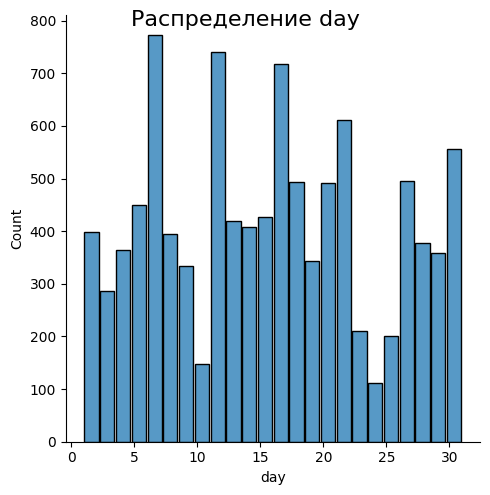

In [15]:
day_hist = sns.displot(df_cleand, x='day', shrink=.9)
day_hist.figure.suptitle(
    'Распределение day', 
    fontsize=16)

Распределение дня последнего контакта адекватное. Аномалий нет. Отлично от нормального.

Text(0.5, 0.98, 'Распределение duration')

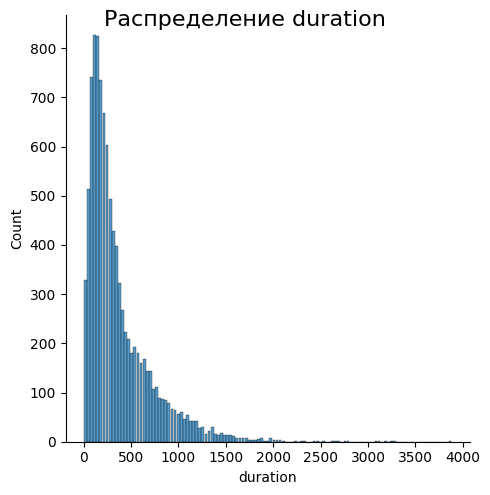

In [16]:
dur_hist = sns.displot(df_cleand, x='duration', shrink=.9)
dur_hist.figure.suptitle(
    'Распределение duration', 
    fontsize=16)

Распределение продолжительности контакта адекватное. Аномалий нет, кроме небольшого числа разговоров длительностью +- час, но это, в-принципе, возможно. Основная масса до 20 минут (а большинство 2-3 минуты, что разумно). Распределение нормальное.

Text(0.5, 0.98, 'Распределение campaign')

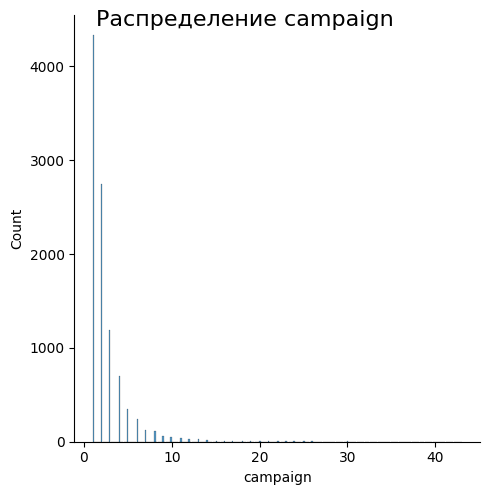

In [17]:
cam_hist = sns.displot(df_cleand, x='campaign', shrink=.9)
cam_hist.figure.suptitle(
    'Распределение campaign', 
    fontsize=16)

Распределение количества контактов в течение текущей кампании адекватное. Аномалий нет. Наимньшее количество 1, наибольшее 43, основна масса сосоредоточне от 1 до 10. Наблюдается снижение с ростом количества контактов. Распределение нормальное.

Text(0.5, 0.98, 'Распределение pdays')

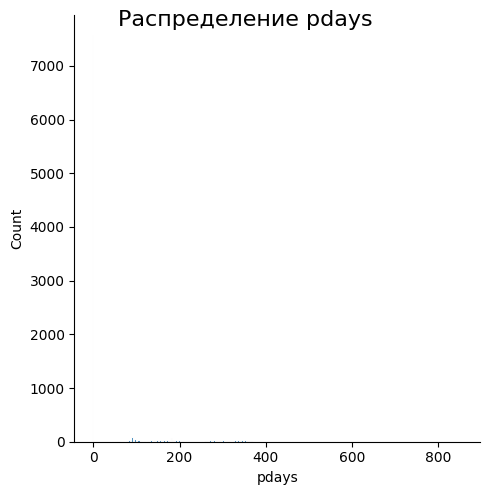

In [18]:
pday_hist = sns.displot(df_cleand, x='pdays', shrink=.9)
pday_hist.figure.suptitle(
    'Распределение pdays', 
    fontsize=16)

Распределение количества пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании имеет аномалии. Максимальное значение 854, возможно, что единичные значения более 200 - это выбросы. Минимальное количество -1, что скорее всего специальное обозначение (количество таких знчений 75 %). Из оставшихся значений большинство находится от 100 до 200. Их распределение похоже на нормальное.

Text(0.5, 0.98, 'Распределение previous')

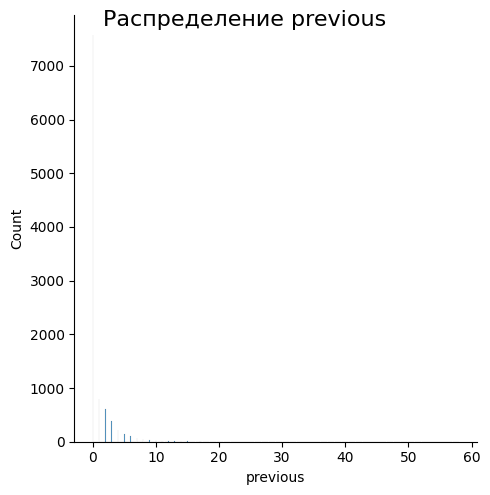

In [19]:
prev_hist = sns.displot(df_cleand, x='previous', shrink=.9)
prev_hist.figure.suptitle(
    'Распределение previous', 
    fontsize=16)

Распределение количества контактов до текущей кампании адекватное. Минимум 0, максимум 58. Большинство равно 0 (около 80 %) и далее уменьшается с ростом количества контактов. Распределение нормальное.

In [20]:
print(f'Максимальный возраст: {df_cleand["age"].max()} лет')

Максимальный возраст: 95 лет


In [21]:
print(f'Минимальная продолжительность разговора с клиентом банка: {df_cleand["duration"].min()} сек')

Минимальная продолжительность разговора с клиентом банка: 2 сек


### Задания 4 и 5

In [22]:
# рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат
df_cleand.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Text(0.5, 1.0, 'Распределение job')

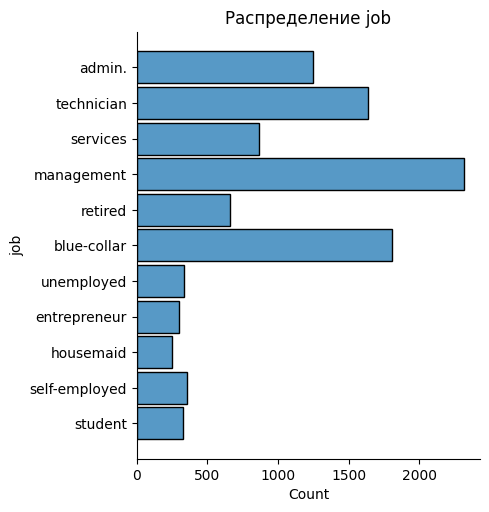

In [23]:
job_hist = sns.displot(df_cleand, y='job', shrink=.9)
job_hist.ax.set_title('Распределение job')

Все видно на графике.

Text(0.5, 1.0, 'Распределение marital')

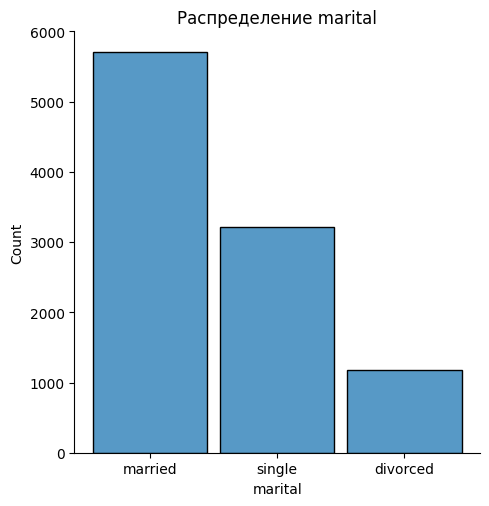

In [24]:
mar_hist = sns.displot(df_cleand, x='marital', shrink=.9)
mar_hist.ax.set_title('Распределение marital')

Женатых около 60 %, одиноких 32 %, остальные  в разводе.

Text(0.5, 1.0, 'Распределение education')

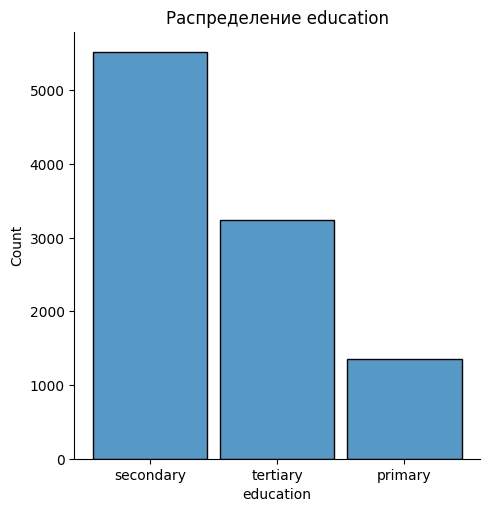

In [25]:
edu_hist = sns.displot(df_cleand, x='education', shrink=.9)
edu_hist.ax.set_title('Распределение education')

Среднее образование 55 %, высшее - 32 % и начальное - 13 %. 

Text(0.5, 1.0, 'Распределение contact')

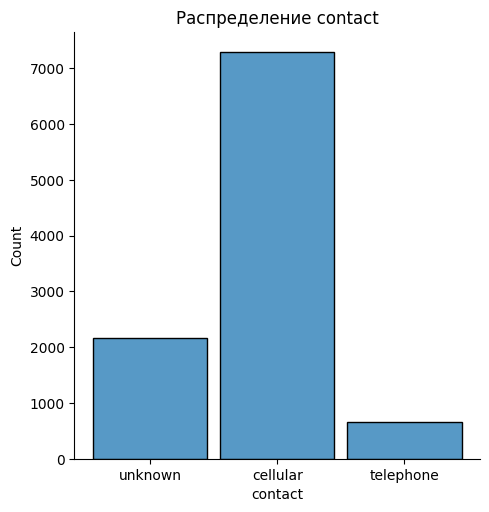

In [26]:
con_hist = sns.displot(df_cleand, x='contact', shrink=.9)
con_hist.ax.set_title('Распределение contact')

Для признака тип контакта неизвестно примерно 22 % значний. При этом три четверти контактов с помощью мобильной связи и 5 % - телефон (стационарный ??).

Text(0.5, 1.0, 'Распределение month')

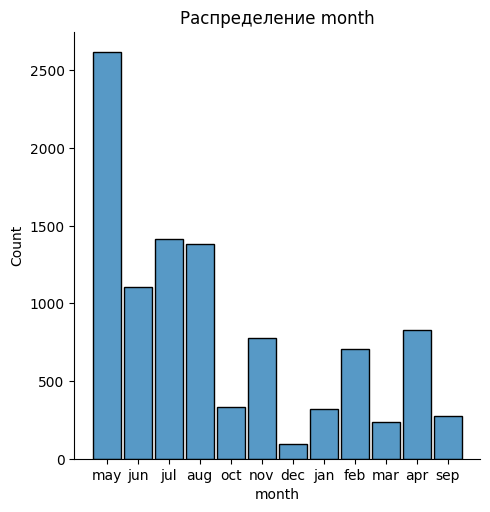

In [27]:
mon_hist = sns.displot(df_cleand, x='month', shrink=.9)
mon_hist.ax.set_title('Распределение month')

Наибольшее количество в мае - четверть. Перед летним сезоном ? Осенью мало, зимой меньше всего (декабрь минимум). При этом февраль несколько выбивается в рост. Лето - стабильно от 1100 до 1500.

Text(0.5, 1.0, 'Распределение poutcome')

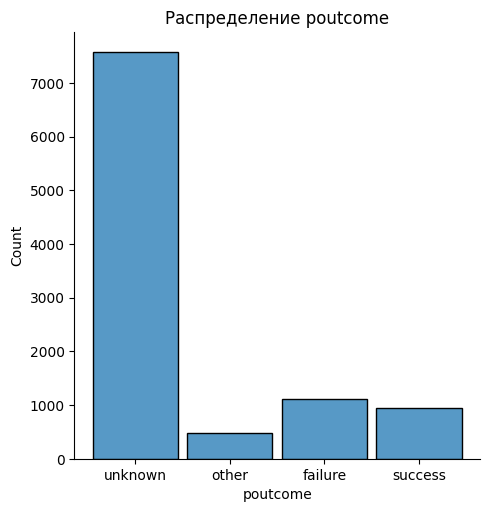

In [28]:
pout_hist = sns.displot(df_cleand, x='poutcome', shrink=.9)
pout_hist.ax.set_title('Распределение poutcome')

Три честверти значений неизвестно. Очень плохо для признака. Для известных значений результат прошлой маркетинговой кампании прмено пополам упеха и неудачи.

Для признаков default, housing и loan все видно из метода describe. Это бинарные признаки. Дефолт у небольшого количества - 1.64 %. Кредит на жилье имеется у половины - 48 %. Кредит на личные нужды имется у, примерно, 14 %.

### Задание 6

Text(0.5, 1.0, 'Распределение статуса предидущей маркетинговой кампании в разрезе успеха нынешней')

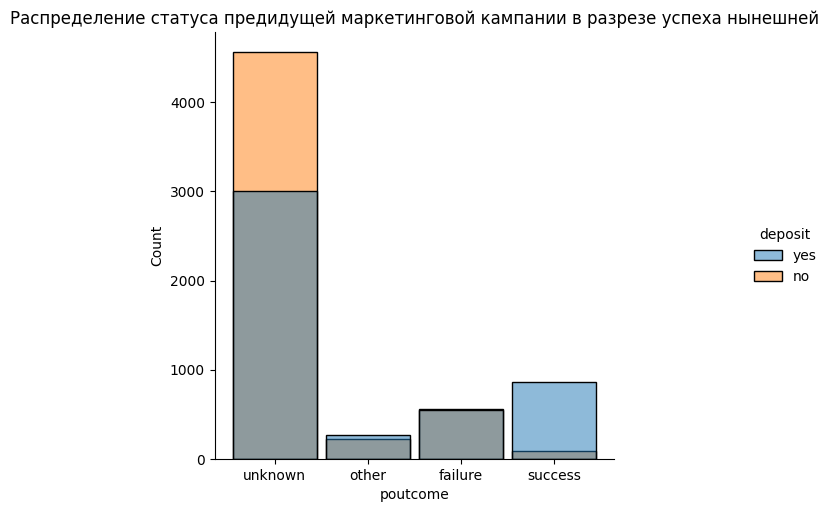

In [29]:
# узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
pout_hist = sns.displot(df_cleand, x='poutcome', shrink=.9, hue='deposit')
pout_hist.ax.set_title('Распределение статуса предидущей маркетинговой кампании в разрезе успеха нынешней')

### Задание 7

Text(0.5, 1.0, 'Распределение month для отказов от открытия депозита')

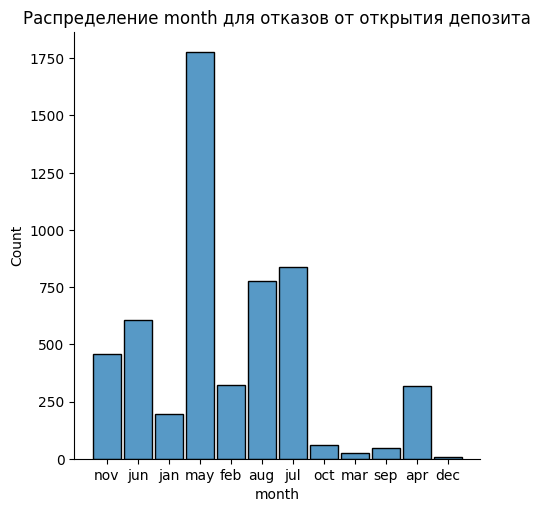

In [30]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит 
# в абсолютном количестве (число отказов по месяцам)
mon_hist = sns.displot(df_cleand[df_cleand['deposit'] == 'no'], x='month', shrink=.9)
mon_hist.ax.set_title('Распределение month для отказов от открытия депозита')

Text(0.5, 1.0, 'Распределение month в разрезе открытия депозита')

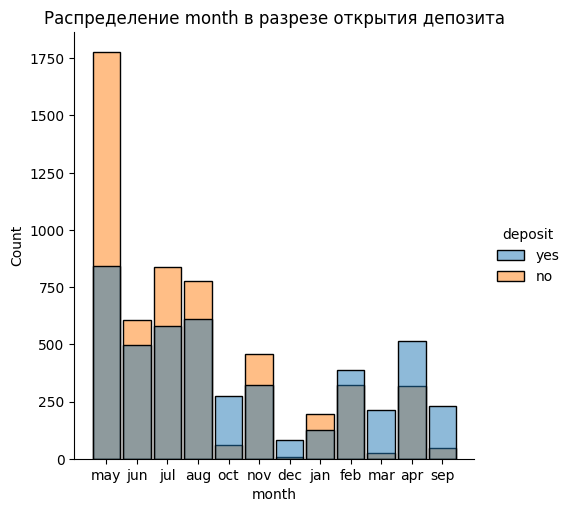

In [31]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит 
# в процентном соотношении отказов к согласию
mon_hist = sns.displot(df_cleand, x='month', shrink=.9, hue='deposit')
mon_hist.ax.set_title('Распределение month в разрезе открытия депозита')

### Задание 8

Text(0.5, 1.0, 'Распределение возрастных групп в разрезе открытия депозита')

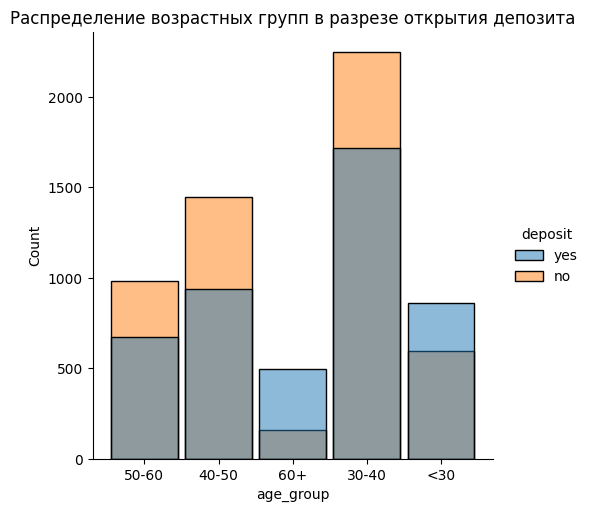

In [32]:
# создадим возрастные группы и определим, в каких группах 
# более склонны открывать депозит, чем отказываться от предложения


def age_group_made(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'
    
df_cleand['age_group'] = df_cleand['age'].apply(age_group_made)

group_hist = sns.displot(df_cleand, x='age_group', shrink=.9, hue='deposit')
group_hist.ax.set_title('Распределение возрастных групп в разрезе открытия депозита')

### Задания 9 и 10

Text(0.5, 1.0, 'Распределение открывших и неоткрывших депозит в зависимости от семейного статуса')

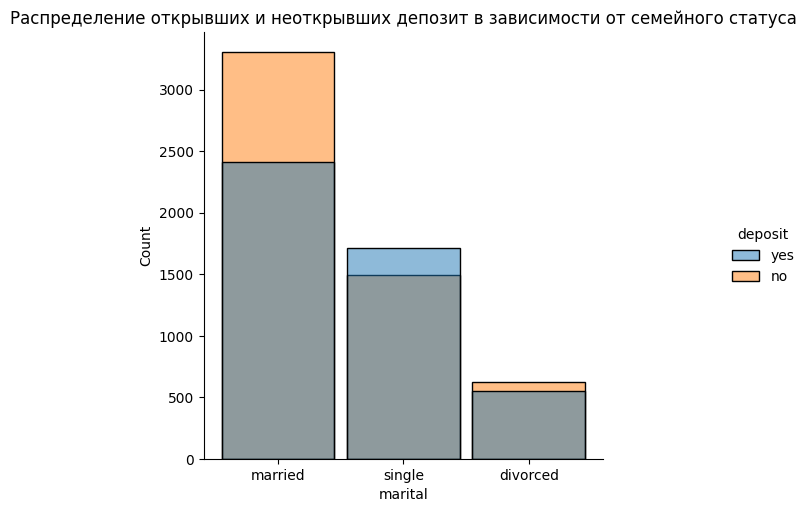

In [33]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
mar_hist = sns.displot(df_cleand, x='marital', shrink=.9, hue='deposit')
mar_hist.ax.set_title('Распределение открывших и неоткрывших депозит в зависимости от семейного статуса')

Одинокие люди чаще открывают депозит, чем не открывают: 53.4 % против 46.6 %. Женатые и разведеные наоборот, чаще не открывают депозит. Причем женатые делают это чаще разведеных: 58 % против 53 %/

Text(0.5, 1.0, 'Распределение открывших и неоткрывших депозит в зависимости от образования')

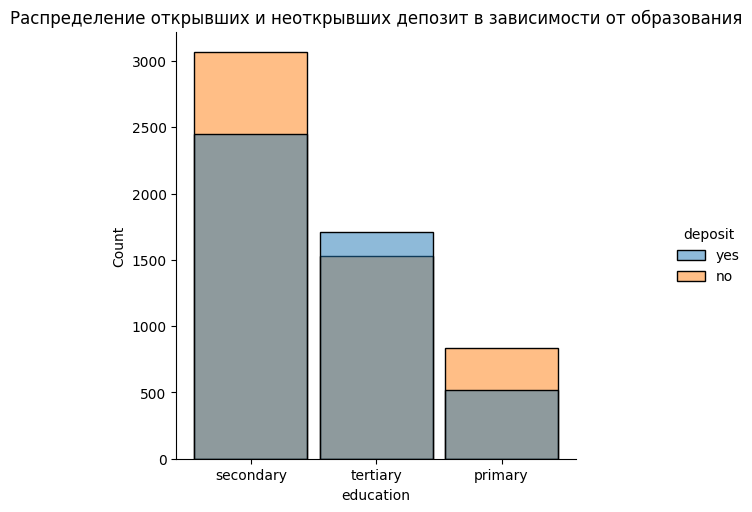

In [34]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования
edu_hist = sns.displot(df_cleand, x='education', shrink=.9, hue='deposit')
edu_hist.ax.set_title('Распределение открывших и неоткрывших депозит в зависимости от образования')

Имеющие высшее образование чаще открывают депозит, чем не открывают: 53 % против 47 %. Люди с начальным и средним образованием чаще не открывают депозит.  Причем с начальным образованием чаще, чем со средним: 62 % против 56 %.

Text(0.5, 1.0, 'Распределение открывших и неоткрывших депозит в зависимости от вида профессиональной занятости')

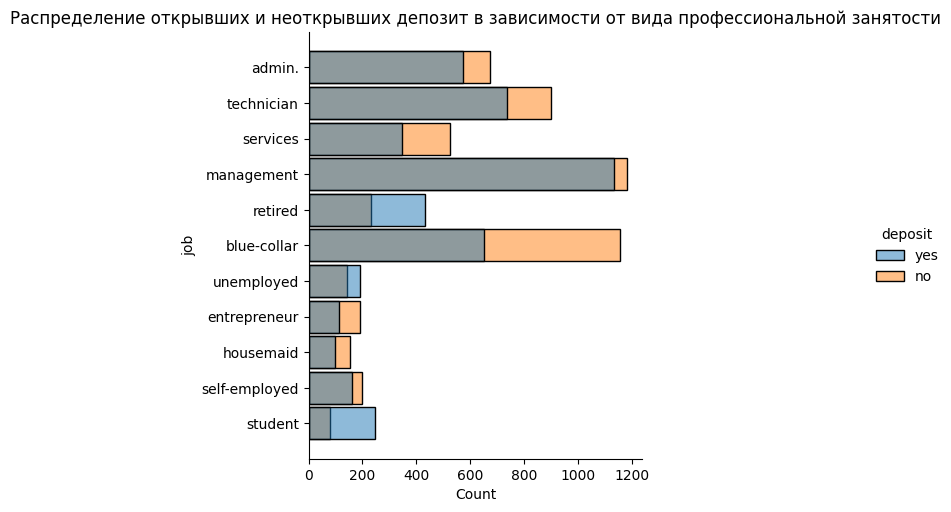

In [35]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job_hist = sns.displot(df_cleand, y='job', shrink=.9, hue='deposit')
job_hist.ax.set_title('Распределение открывших и неоткрывших депозит в зависимости от вида профессиональной занятости')

### Задание 11

Text(0.5, 0.98, 'Зависимость открытия депозита от образования и семейного статуса')

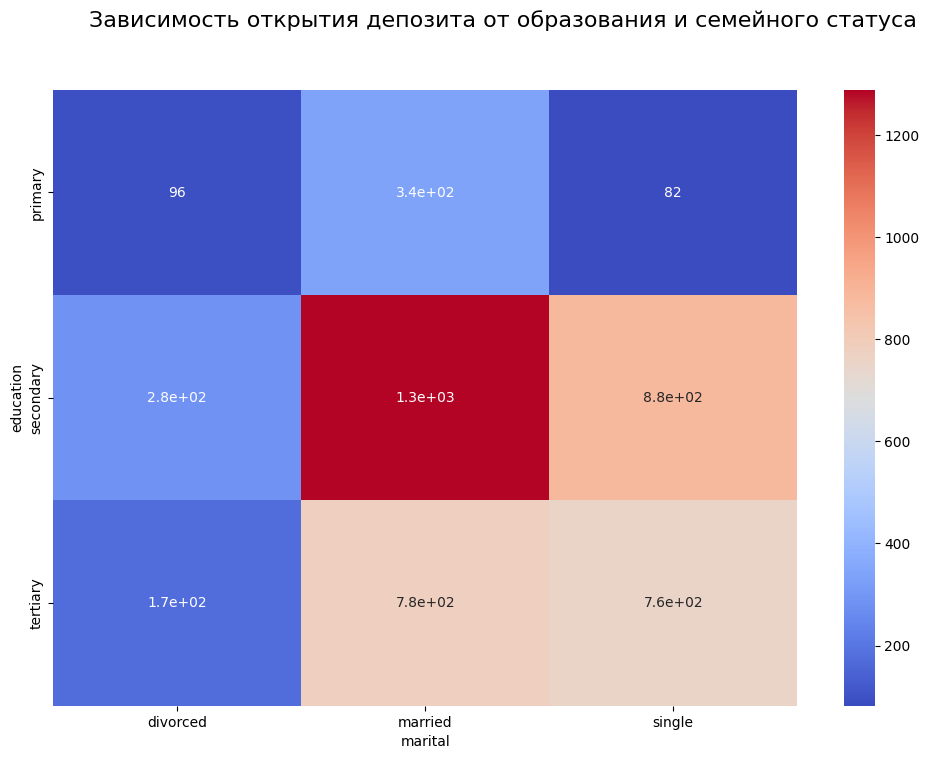

In [36]:
# построим сводную таблицу, чтобы определить люди с каким образованием и 
# семейным статусом наиболее многочисленны (если рассматривать тех, кто открыл депозит)
pivot = pd.pivot_table(
    data=df_cleand[df_cleand['deposit'] == 'yes'],
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count'
)

plt.figure(figsize = (12,8))
heat_2 = sns.heatmap(pivot, annot=True, cmap='coolwarm')
heat_2.figure.suptitle(
    'Зависимость открытия депозита от образования и семейного статуса', 
    fontsize=16)

## Часть 3: преобразование данных

### Задание 1

In [37]:
# преобразуем уровни образования (закодируем)
le = preprocessing.LabelEncoder()
df_cleand['education'] = le.fit_transform(df_cleand['education'])

df_cleand['education'].sum()

11995

In [38]:
# преобразуем группы возраста (закодируем)
le = preprocessing.LabelEncoder()
df_cleand['age_group'] = le.fit_transform(df_cleand['age_group'])

### Задания 2 и 3

In [39]:
# преобразуем бинарные переменные в представление из нулей и единиц
df_cleand['deposit'] = df_cleand['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleand['default'] = df_cleand['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleand['housing'] = df_cleand['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleand['loan'] = df_cleand['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [40]:
# вычислим стандартное отклонение признака deposit
round(df_cleand['deposit'].std(), 3)

0.499

In [41]:
# вычислим сумму стандартных отклонений признаков:
# default, housing, loan
round(df_cleand['default'].mean() + df_cleand['housing'].mean() + df_cleand['loan'].mean(), 3)

0.635

### Задание 4

In [42]:
# создадим дамми-переменные оставшихся категориальных переменных
df_cleand = pd.get_dummies(df_cleand, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

### Задания 5 и 6

Text(0.5, 0.98, 'Корреляционная матрица')

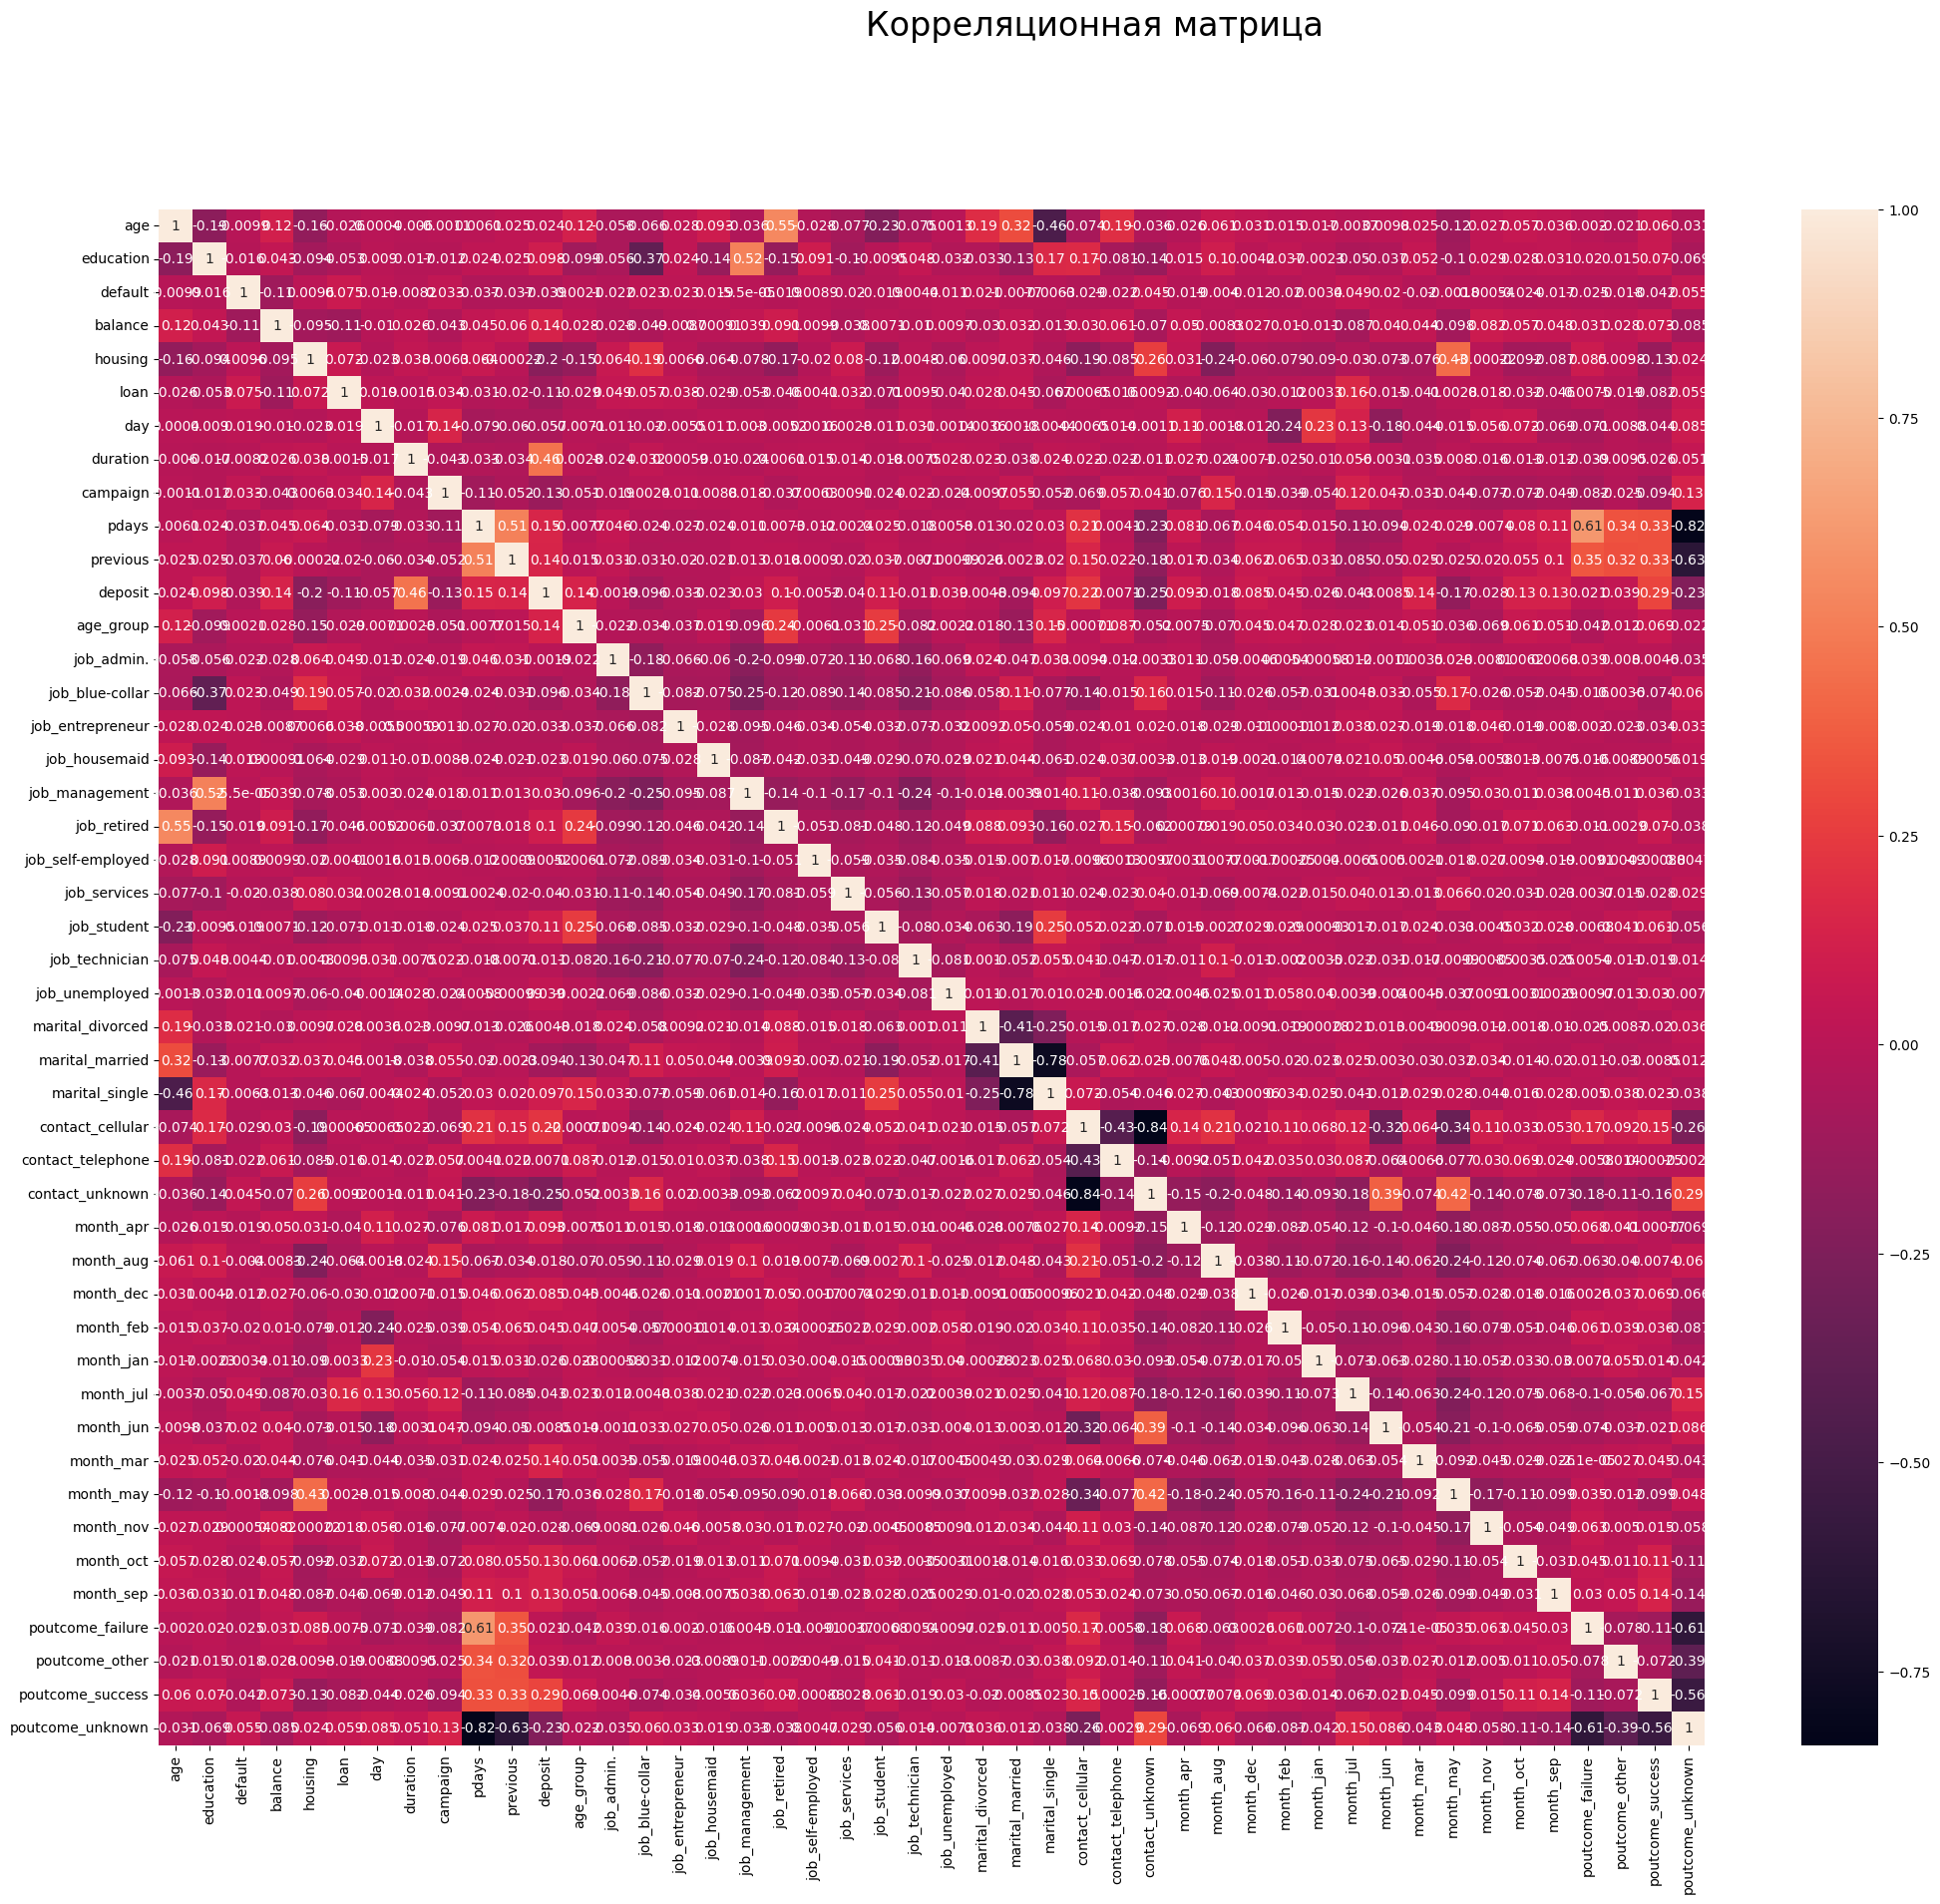

In [43]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (25,20))
heat_corr = sns.heatmap(df_cleand.corr(), annot=True)
heat_corr.figure.suptitle(
    'Корреляционная матрица', 
    fontsize=24)

### Задания 7 и 8

In [44]:
# определим целевую переменную и матрицу признаков
X = df_cleand.drop(['deposit'], axis=1)
y = df_cleand['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [45]:
# рассчитаем необходимые показатели
print(f'Размер тествовой выборки: {X_test.shape[0]}')
print(f'Среднее значение целевой переменной на тестовой выборке: {round(y_test.mean(), 2)}')

Размер тествовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [46]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
fs = SelectKBest(k=15)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [47]:
# выведем 15 отобранных признаков
selected_features = fs.get_feature_names_out()
print(selected_features)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [48]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_fs)
X_train_fs_scaled = scaler.transform(X_train_fs)
X_test_fs_scaled = scaler.transform(X_test_fs)

print(f'Среднее для 1 го предиктора тестовой выборки: {round(X_test_fs_scaled[:, 0].mean(), 2)}')

Среднее для 1 го предиктора тестовой выборки: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [49]:
# обучим логистическую регрессию и рассчитаем метрику качества accuracy
lr = linear_model.LogisticRegression(
                                     solver='sag', 
                                     random_state=42, 
                                     max_iter=1000
                                     )
lr.fit(X_train_fs_scaled, y_train)
y_pred_lr = lr.predict(X_test_fs_scaled)

print(f'Значение метрики accuracy для тестовой выборки: {round(metrics.accuracy_score(y_test, y_pred_lr), 2)}')

Значение метрики accuracy для тестовой выборки: 0.8


### Задания 2,3,4

In [50]:
# обучим решающие деревья, настроив максимальную глубину
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train_fs_scaled, y_train)
y_pred_train = dt.predict(X_train_fs_scaled)
y_pred_test = dt.predict(X_test_fs_scaled)

print(f'Метрики для тренировочной выборки: \n \n {metrics.classification_report(y_train, y_pred_train)}')
print()
print(f'Метрики для тестовой выборки: \n \n{metrics.classification_report(y_test, y_pred_test)}')

Метрики для тренировочной выборки: 
 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770


Метрики для тестовой выборки: 
 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Text(0, 0.5, 'accuracy')

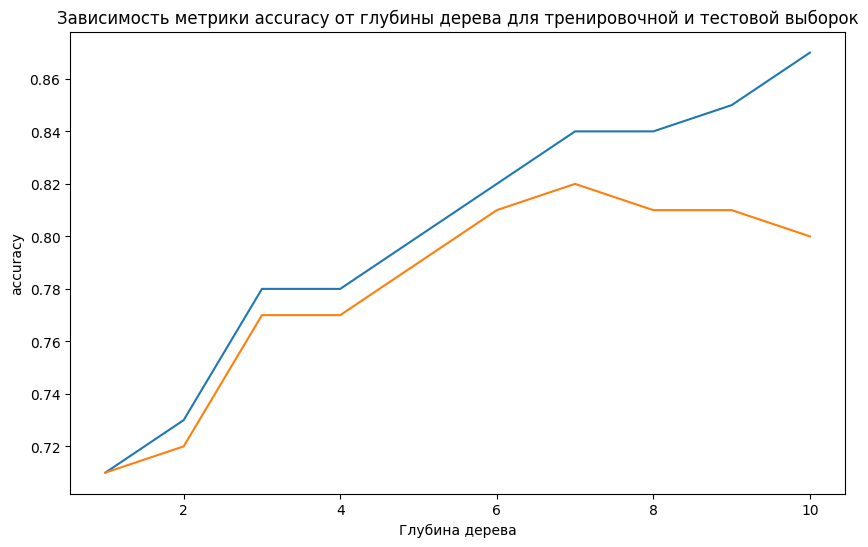

In [51]:
# обучим решающие деревья, настроив максимальную глубину таким образом, 
# чтобы было максимальное значение метрики accuracy для тестовой выборки, 
# но при этом ещё не было переобучения (т. е. не росло качество на обучающей 
# выборке при неизменном качестве на тестовой)
train = []
test = []

for i in range(1,11):
    dt = tree.DecisionTreeClassifier(
                                     criterion='entropy', 
                                     random_state=42, 
                                     max_depth=i
                                     )
    dt.fit(X_train_fs_scaled, y_train)
    
    pred_train = dt.predict(X_train_fs_scaled)
    train.append(round(metrics.accuracy_score(y_train, pred_train), 2))
    pred_test = dt.predict(X_test_fs_scaled)
    test.append(round(metrics.accuracy_score(y_test, pred_test), 2))

line,ax = plt.subplots(figsize=(10,6))
sns.lineplot(x=range(1, 11), y=train)
sns.lineplot(x=range(1, 11), y=test)
ax.set_title("Зависимость метрики accuracy от глубины дерева для тренировочной и тестовой выборок", fontsize=12)
ax.set_xlabel ("Глубина дерева")
ax.set_ylabel ("accuracy")

In [52]:
# обучим решающие деревья при максимальной глубине 6
dt = tree.DecisionTreeClassifier(
                                 criterion='entropy', 
                                 random_state=42, 
                                 max_depth=6
                                 )
dt.fit(X_train_fs_scaled, y_train)

y_pred_dt = dt.predict(X_test_fs_scaled)
print(f'Значение метрики accuracy для тестовой выборки при максимальной глубине 6: {round(metrics.accuracy_score(y_test, y_pred_dt), 2)}')

Значение метрики accuracy для тестовой выборки при максимальной глубине 6: 0.81


### Задание 5

In [53]:
# подберем оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    n_jobs = -1
)  

%time grid_search.fit(X_train_fs_scaled, y_train) 

y_pred_grid = grid_search.predict(X_test_fs_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_grid)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 234 ms
Wall time: 2.49 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [54]:
# обучим случайный лес и оценим метрики 
# accuracy и recall для тестовой выборки
rf = ensemble.RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10,
                                     random_state = 42
)

rf.fit(X_train_fs_scaled, y_train)
y_pred_rf = rf.predict(X_test_fs_scaled)

print(f'Метрики для тестовой выборки: \n \n{metrics.classification_report(y_test, y_pred_rf)}')

Метрики для тестовой выборки: 
 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [55]:
# используем для классификации градиентный бустинг 
# и сравним качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf = 5,
        max_depth=5,
        random_state=42
)

gb.fit(X_train_fs_scaled, y_train)

y_pred_gb = gb.predict(X_test_fs_scaled)
print(f'Метрики для тестовой выборки: \n \n{metrics.classification_report(y_test, y_pred_gb)}')

Метрики для тестовой выборки: 
 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



С использованными параметрами нет разницы между градиентным бустингом и случайным лесом. 

### Задание 4

In [56]:
# объединим использованные алгоритмы с помощью стекинга, 
# а именно - решающие деревья, логистическую регрессию и градиентный бустинг, 
# в качестве метамодели используем модель логистической регрессии
estimators = [
    ('lr', linear_model.LogisticRegression(
            solver='sag',
            random_state=42,
            max_iter=1000)),
    ('dt', tree.DecisionTreeClassifier(
            criterion='entropy',
            random_state=42,
            max_depth=6)),
    ('gb', ensemble.GradientBoostingClassifier(
            learning_rate=0.05,
            n_estimators=300,
            min_samples_leaf = 5,
            max_depth=5,
            random_state=42))
]

clf = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000
    ),
    n_jobs=-1
)

clf.fit(X_train_fs_scaled, y_train)
y_pred_reg = clf.predict(X_test_fs_scaled)

print(f'Метрики для тестовой выборки: \n \n{metrics.classification_report(y_test, y_pred_reg)}')

Метрики для тестовой выборки: 
 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

Text(0, 0.5, 'Признаки')

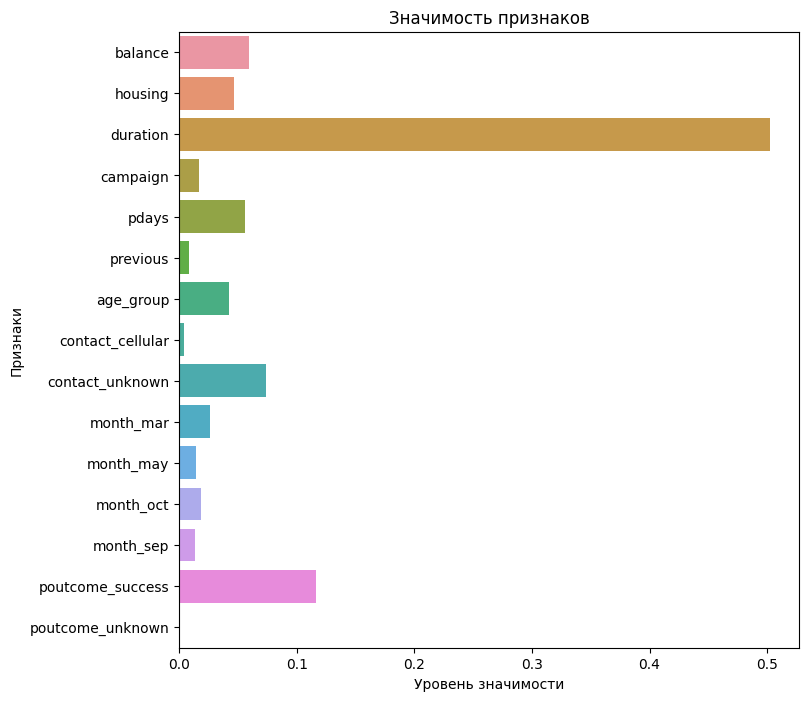

In [57]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
line,ax = plt.subplots(figsize=(8,8))
sns.barplot(x=gb.feature_importances_, y=selected_features)
ax.set_title('Значимость признаков', fontsize=12)
ax.set_xlabel ('Уровень значимости')
ax.set_ylabel ('Признаки')


### Задания 6,7,8

In [58]:
%%time
# реализуем оптимизацию гиперпараметров с помощью Optuna
# и получим значение метрики f1 на тестовой выборке

import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  
  model.fit(X_train_fs_scaled, y_train)
  
  score = metrics.f1_score(y_train, model.predict(X_train_fs_scaled))
  
  return score


study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_fs_scaled, y_train)
y_test_pred = model.predict(X_test_fs_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-07-02 16:59:38,590] A new study created in memory with name: RandomForestClassifier
[I 2023-07-02 16:59:39,292] Trial 0 finished with value: 0.8506971643427854 and parameters: {'n_estimators': 143, 'max_depth': 22, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8506971643427854.
[I 2023-07-02 16:59:40,175] Trial 1 finished with value: 0.8609416549350852 and parameters: {'n_estimators': 169, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8609416549350852.
[I 2023-07-02 16:59:41,058] Trial 2 finished with value: 0.8532124433328122 and parameters: {'n_estimators': 173, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8609416549350852.
[I 2023-07-02 16:59:41,793] Trial 3 finished with value: 0.8620635666196962 and parameters: {'n_estimators': 138, 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8620635666196962.
[I 2023-07-02 16:59:42,576] Trial 4 finished with value: 0.8692391813779097 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на тестовом наборе: 0.81
CPU times: total: 20.8 s
Wall time: 20.9 s


In [59]:
print(f'Метрики для тестовой выборки: \n \n{metrics.classification_report(y_test, y_test_pred)}')

Метрики для тестовой выборки: 
 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.84      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

